<center>
  <h2>Trabajo Laboratorio de Implementación III - MCD Virtual Cohorte 2022</h2>
  <h3>Forecasting para una Empresa de Consumo Masivo</h3>
  <h4>Armado de Datasets - Mejora data relacionada a nivel producto</h4>
</center>

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import warnings
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
warnings.filterwarnings("ignore")

date_start=datetime.strptime('2017-01-01', '%Y-%m-%d')
date_end=datetime.strptime('2019-12-01', '%Y-%m-%d')
forecast_length = 2
date_future=date_end+relativedelta(months=forecast_length)
years=range(2018, 2020)

In [2]:
print(f"Fecha inicio historia {date_start}")
print(f"Fecha fin historia {date_end}")
print(f"Fecha futura (related time series) {date_future}")

Fecha inicio historia 2017-01-01 00:00:00
Fecha fin historia 2019-12-01 00:00:00
Fecha futura (related time series) 2020-02-01 00:00:00


- Skus a predecir

In [3]:
skus_a_predecir = pd.read_csv("C:/Users/usuario/otros/Desktop\MCD/6 Labo III/Forecasting Problem/Datasets/productos_a_predecir.txt", delimiter='\t')
skus_a_predecir = skus_a_predecir.product_id.to_list()

- Datos de ventas

In [4]:
df_ventas = pd.read_csv("C:/Users/usuario/otros/Desktop\MCD/6 Labo III/Forecasting Problem/Datasets/sell-in.txt", delimiter='\t')
df_ventas['periodo'] = df_ventas['periodo'].astype(str)
df_ventas['periodo'] = pd.to_datetime(df_ventas['periodo'], format='%Y%m')
df_ventas = df_ventas[df_ventas.product_id.isin(skus_a_predecir)]
df_ventas.head(1)

,periodo,customer_id,product_id,plan_precios_cuidados,cust_request_qty,cust_request_tn,tn
0,2017-01-01,10234,20524,0,2,0.053,0.053


In [5]:
print(f"Cantidad productos finales a predecir: {len(df_ventas.product_id.drop_duplicates())}")

Cantidad productos finales a predecir: 780


Dataset de ventas para predecir unicamente por periodo y producto:

In [6]:
df_ventas_product = df_ventas.groupby(["periodo", "product_id"])["tn"].sum().reset_index()
df_ventas_product.head(1)

,periodo,product_id,tn
0,2017-01-01,20001,934.77222


In [7]:
df_ventas_product.isna().sum()

periodo       0
product_id    0
tn            0
dtype: int64

In [8]:
df_ventas_product.tn.sum().round(1) == df_ventas.tn.sum().round(1) 

True

In [9]:
# Exportamos data de ventas product
df_ventas_product_export = df_ventas_product[(df_ventas_product['periodo']>=date_start) & (df_ventas_product['periodo']<=date_end)]
df_ventas_product_export['product_id'] = df_ventas_product_export['product_id'].astype(str)
print(f"Min periodo {df_ventas_product_export.periodo.min()}")
print(f"Max periodo {df_ventas_product_export.periodo.max()}")
df_ventas_product_export.to_csv("C:/Users/usuario/otros/Desktop\MCD/6 Labo III/Forecasting Problem/Datasets/df_ventas_product_v1.csv", index=False, header=False)
print(f"Tipos por columna: \n{df_ventas_product_export.dtypes}")

Min periodo 2017-01-01 00:00:00
Max periodo 2019-12-01 00:00:00
Tipos por columna: 
periodo       datetime64[ns]
product_id            object
tn                   float64
dtype: object


- Datos de producto

In [10]:
producto = pd.read_csv("C:/Users/usuario/otros/Desktop\MCD/6 Labo III/Forecasting Problem/Datasets/tb_productos.txt", delimiter='\t')
producto.head(5)

,cat1,cat2,cat3,brand,sku_size,product_id
0,HC,ROPA LAVADO,Liquido,LIMPIEX,900,20280
1,HC,ROPA LAVADO,Liquido,LIMPIEX,450,20180
2,HC,ROPA LAVADO,Liquido,LIMPIEX,120,20332
3,HC,ROPA LAVADO,Liquido,LIMPIEX,450,20222
4,HC,ROPA LAVADO,Liquido,LIMPIEX,900,20288


In [11]:
print("----ANALISIS DUPLICADOS-----")
print(f"Cantidad productos en maestro productos: {len(producto)}")
print(f"Cantidad productos en maestro productos sin repetidos: {len(producto.product_id.drop_duplicates())}")
# Observamos que product_id duplicados tienen los mismos valores en las otras columnas, son duplicados y procedemos a eliminarlos 
producto = producto.drop_duplicates(subset = "product_id")
print(f"Cantidad productos en maestro productos: {len(producto)}")

----ANALISIS DUPLICADOS-----
Cantidad productos en maestro productos: 1262
Cantidad productos en maestro productos sin repetidos: 1251
Cantidad productos en maestro productos: 1251


In [12]:
producto = producto[producto.product_id.isin(skus_a_predecir)]
print(f"Cantidad productos finales a predecir: {len(producto)}")

Cantidad productos finales a predecir: 780


In [30]:
producto = producto[["product_id", "cat1", "cat2", "cat3", "brand", "sku_size"]]
producto['product_id'] = producto['product_id'].astype(str)
producto.to_csv("C:/Users/usuario/otros/Desktop\MCD/6 Labo III/Forecasting Problem/Datasets/df_products_v1.csv", index=False, header=False)
print(f"Tipos por columna \n{producto.dtypes}")

Tipos por columna 
product_id    object
cat1          object
cat2          object
cat3          object
brand         object
sku_size       int64
dtype: object


- Creación serie de tiempo relacionada

Agregamos fechas faltantes para tener todos los puntos de historia y no sólo donde tenemos venta registrada

In [153]:
def create_future_periods(df):
    combination = df.groupby([i for i in ['product_id']])["periodo"].apply(lambda s: pd.date_range(s.min(), date_future, freq='MS')).explode().reset_index()
    result = pd.merge(combination, df, how = "left", on = ["periodo", "product_id"])
    result = result[["periodo", "product_id", "tn"]]
    return result

In [154]:
df_related_product_v1 = create_future_periods(df_ventas_product)

Agregamos variable relativas a tiempo

In [155]:
def time_features(df):
    df_time_features = df.copy()
    # Asegúrate de que la columna 'periodo' esté en formato datetime
    df_time_features['periodo'] = pd.to_datetime(df_time_features['periodo'], format='%Y-%m-%d')
    # Crear las columnas 'mes', 'cuatrimestre' y 'dias del mes"
    df_time_features['month'] = df_time_features['periodo'].dt.month
    df_time_features['quarter'] = df_time_features['periodo'].dt.quarter
    df_time_features['days_in_month']= df_time_features['periodo'].dt.daysinmonth
    return df_time_features

In [156]:
df_related_product_v2 = time_features(df_related_product_v1)

Agregamos cantidad de sabados y domingos del mes

In [157]:
# Cantidad de domingos al mes
sundays = pd.DataFrame(pd.date_range(start=pd.to_datetime(date_start), end=date_future + pd.offsets.MonthEnd(0)))
# sundays = pd.DataFrame(pd.date_range(start=pd.to_datetime(date_start) - pd.DateOffset(years=1), end=date_future + pd.offsets.MonthEnd(0)))
sundays.columns = ["fecha"]
sundays["day_week"] = pd.to_datetime(sundays['fecha'], format='%Y-%m-%d').dt.dayofweek
sundays = sundays[sundays.day_week == 6].rename(columns = {"day_week":"sundays"})
sundays = sundays.replace({6:1})
sundays['periodo']=sundays['fecha'].apply(lambda x: x.replace(day=1))
sundays = sundays.groupby(["periodo"])["sundays"].sum().reset_index()
sundays['periodo']=pd.to_datetime(sundays['periodo'], format='%Y-%m-%d')
sundays["sundays"] = sundays["sundays"].astype(int)
# Cantidad de sabados al mes
saturdays = pd.DataFrame(pd.date_range(start=pd.to_datetime(date_start), end=date_future + pd.offsets.MonthEnd(0)))
# saturdays = pd.DataFrame(pd.date_range(start=pd.to_datetime(date_start) - pd.DateOffset(years=1), end=date_future + pd.offsets.MonthEnd(0)))
saturdays.columns = ["fecha"]
saturdays["day_week"] = pd.to_datetime(saturdays['fecha'], format='%Y-%m-%d').dt.dayofweek
saturdays = saturdays[saturdays.day_week == 5].rename(columns = {"day_week":"saturdays"})
saturdays = saturdays.replace({5:1})
saturdays['periodo']=saturdays['fecha'].apply(lambda x: x.replace(day=1))
saturdays = saturdays.groupby(["periodo"])["saturdays"].sum().reset_index()
saturdays["saturdays"] = saturdays["saturdays"].astype(int)
saturdays['periodo']=pd.to_datetime(saturdays['periodo'], format='%Y-%m-%d')
# DF conjunto
sundays_saturdays = pd.merge(sundays, saturdays, how = "inner", on = "periodo")
sundays_saturdays.head(5)

,periodo,sundays,saturdays
0,2017-01-01,5,4
1,2017-02-01,4,4
2,2017-03-01,4,4
3,2017-04-01,5,5
4,2017-05-01,4,4


In [158]:
df_related_product_v3 = pd.merge(df_related_product_v2, sundays_saturdays, how = "left", on = "periodo")

- Agregamos desfasajes y lags de los últimos 12 meses

In [159]:
def shift_series(df, columns_shift):
    df_shift = df.copy()
    df_shift = df_shift.sort_values(by=columns_shift + ["periodo"])
    lags = range(1, 13)
    for lag in lags:
        df_shift[f'lag{lag}m'] = df_shift.groupby(columns_shift)['tn'].shift(lag)
        deltas = range(1, 13) 
    for delta in deltas:
        df_shift[f'delta{delta}'] = df_shift.groupby(columns_shift)['tn'].diff(periods=delta)
    return df_shift

In [162]:
df_related_product_v4 = shift_series(df_related_product_v3, columns_shift = ["product_id"])
# Los puntos de tn con nan durante el periodo de train, son rellenados con cero, para el futuro se quedan con nan
df_related_product_v4["tn"] = np.where(df_related_product_v4["periodo"] <= date_end, df_related_product_v4["tn"].fillna(0), df_related_product_v4["tn"])
df_related_product_v4[df_related_product_v4.periodo > date_end].tn.unique()

array([nan])

Agregamos feature de % de ventas mensual sobre el total anual (por product_id) para recoger estacionalidad

In [171]:
def calculate_monthly_percentage(df, columns_shift):
    df_pesos = df.copy()
    df_pesos["year"] = df_pesos.periodo.dt.year
    # Calcular el volumen total anual por product_id
    annual_volume = df_pesos.groupby(columns_shift + ['year'])['tn'].sum().reset_index()
    annual_volume.rename(columns={'tn': 'annual_tn'}, inplace=True)
    # Unir el volumen anual de vuelta al DataFrame original
    df_pesos = pd.merge(df_pesos, annual_volume, on=columns_shift + ['year'], how='left')
    # Calcular el porcentaje del volumen mensual respecto al volumen anual (por año)
    df_pesos['monthly_percentage'] = df_pesos['tn'] / df_pesos['annual_tn'] * 100
    # Crear una columna shifted_monthly_percentage con el valor de monthly_percentage hace 12 meses
    df_pesos['shifted_monthly_percentage'] = df_pesos.groupby(columns_shift)['monthly_percentage'].shift(12)
    # Rellenar los NaN en monthly_percentage con los valores de shifted_monthly_percentage (serían los valores futuros)
    df_pesos['monthly_percentage'] = df_pesos['monthly_percentage'].fillna(df_pesos['shifted_monthly_percentage'])
    # Eliminar las columnas tn, shifted_monthly_percentage y year si no son necesarias
    df_pesos = df_pesos.drop(columns=['shifted_monthly_percentage', 'year', 'annual_tn'])
    df_pesos['monthly_percentage'] = df_pesos['monthly_percentage'].fillna(0)
    return df_pesos

In [172]:
df_related_product_v5 = calculate_monthly_percentage(df_related_product_v4, columns_shift = ["product_id"])

Agregamos variables dummy que recogen outliers mínimos y máximos

In [182]:
def calculate_sales_extreme_values_by_percentile_method(df, lower_quantile=0.05, upper_quantile=0.95, grouped_columns=[]):
    '''Calculates sales extreme values for those that are 
    greater/less than a lower/upper percentile.
    '''
    def upperextreme(x):
        '''Define Upper Extreme'''
        return x.quantile(q=upper_quantile)
    def lowerextreme(x):
        '''Define Lower Extreme'''
        return x.quantile(q=lower_quantile)
    
    # Calculate extreme values by grouped_columns
    df_lower_upper_extremes = df.groupby(grouped_columns)["tn"].agg([lowerextreme, upperextreme]).reset_index()
    
    # Add extreme value dummies
    df = (df
         .merge(df_lower_upper_extremes, on = grouped_columns)
         .assign(
             lowerextremepoint = lambda x: x.tn < x.lowerextreme,
             upperextremepoint = lambda x: x.tn > x.upperextreme)
         .assign(
             lowerextremepoint = lambda x: x.lowerextremepoint.astype('int64'),
             upperextremepoint = lambda x: x.upperextremepoint.astype('int64'))
         .drop(columns = ['lowerextreme', 'upperextreme'])
    )
    # Seteamos valores nan para periodo futuro
    df["lowerextremepoint"] = np.where(df["periodo"] <= date_end, df["lowerextremepoint"], np.nan)
    df["upperextremepoint"] = np.where(df["periodo"] <= date_end, df["upperextremepoint"], np.nan)
    return df

In [183]:
df_related_product_v6 = calculate_sales_extreme_values_by_percentile_method(df_related_product_v5, 
                                                                            lower_quantile=0.05, 
                                                                            upper_quantile=0.95, 
                                                                            grouped_columns=["product_id"])

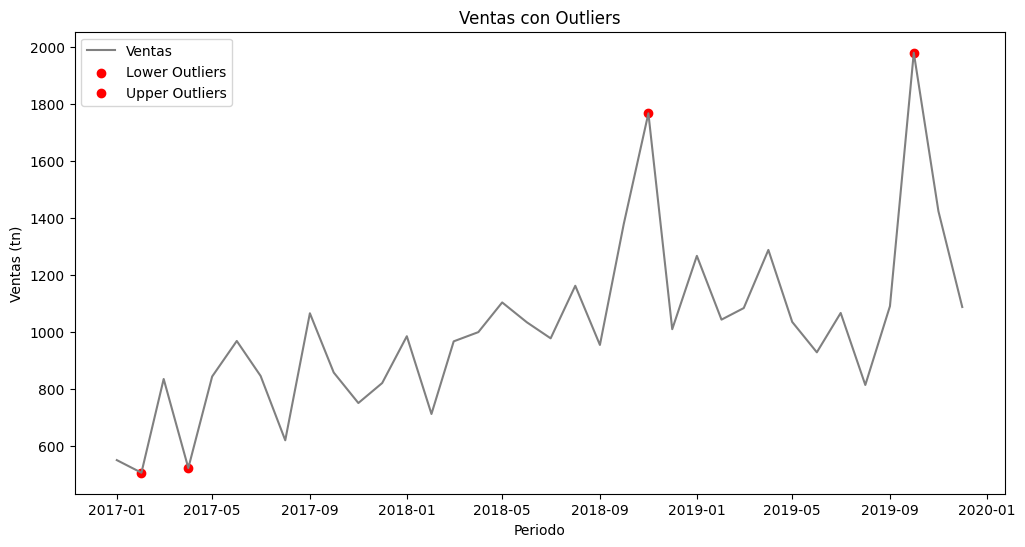

In [184]:
producto_select = df_related_product_v6[(df_related_product_v6.product_id == 20002)][["periodo", "tn", "lowerextremepoint", "upperextremepoint"]]
def plot_outliers(df):
    '''
    Grafica la serie de tiempo de tn, marcando con puntos rojos los lowerextremepoint y upperextremepoint.
    
    Parámetros:
    df (pd.DataFrame): DataFrame con columnas ['periodo', 'tn', 'lowerextremepoint', 'upperextremepoint']
    '''
    # Convertir 'periodo' a tipo datetime si no lo está
    if not pd.api.types.is_datetime64_any_dtype(df['periodo']):
        df['periodo'] = pd.to_datetime(df['periodo'])
    # Filtrar los puntos extremos
    df_lower = df[df['lowerextremepoint'] == 1]
    df_upper = df[df['upperextremepoint'] == 1]
    # Graficar la serie de tiempo
    plt.figure(figsize=(12, 6))
    plt.plot(df['periodo'], df['tn'], color='gray', label='Ventas')
    # Marcar los lowerextremepoint y upperextremepoint
    plt.scatter(df_lower['periodo'], df_lower['tn'], color='red', label='Lower Outliers')
    plt.scatter(df_upper['periodo'], df_upper['tn'], color='red', label='Upper Outliers')
    # Añadir título y etiquetas
    plt.title('Ventas con Outliers')
    plt.xlabel('Periodo')
    plt.ylabel('Ventas (tn)')
    plt.legend()
    # Mostrar la gráfica
    plt.show()
plot_outliers(producto_select)

In [185]:
df_related_product_v7 = df_related_product_v6.drop(columns="tn")
df_related_product_v7.head(5)

,periodo,product_id,month,quarter,days_in_month,sundays,saturdays,lag1m,lag2m,lag3m,lag4m,lag5m,lag6m,lag7m,lag8m,lag9m,lag10m,lag11m,lag12m,delta1,delta2,delta3,delta4,delta5,delta6,delta7,delta8,delta9,delta10,delta11,delta12,monthly_percentage,lowerextremepoint,upperextremepoint
0,2017-01-01,20001,1,1,31,5,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.310483,1.0,0.0
1,2017-02-01,20001,2,1,28,4,4,934.77222,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-136.75602,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.387267,1.0,0.0
2,2017-03-01,20001,3,1,31,4,4,798.01620,934.77222,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,505.34151,368.58549,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.798738,0.0,0.0
3,2017-04-01,20001,4,2,30,5,5,1303.35771,798.01620,934.77222,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-233.39641,271.94510,135.18908,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.223120,0.0,0.0
4,2017-05-01,20001,5,2,31,4,4,1069.96130,1303.35771,798.01620,934.77222,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,432.24002,198.84361,704.18512,567.4291,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.141096,0.0,0.0


In [186]:
len(df_related_product_v7) == len(df_related_product_v1)

True

In [187]:
# Exportamos data relacionada, apertura por product
# Nos aseguramos que cada serie temporal (por producto) comience en el mismo periodo que comienza en la serie de tiempo ppal de ventas
df_min_period = df_ventas_product_export.groupby(["product_id"])["periodo"].min().reset_index().rename(columns = {"periodo":"min_periodo"})
df_related_product_v7['product_id'] = df_related_product_v7['product_id'].astype(str)
df_related_product_export = pd.merge(df_related_product_v7, df_min_period, on='product_id')
df_related_product_export = df_related_product_export[df_related_product_export['periodo'] >= df_related_product_export['min_periodo']]
df_related_product_export = df_related_product_export.drop(columns=['min_periodo'])
df_related_product_export = df_related_product_export[(df_related_product_export['periodo']<=date_future)]
df_related_product_export.to_csv("C:/Users/usuario/otros/Desktop\MCD/6 Labo III/Forecasting Problem/Datasets/df_related_product_v1.csv", index=False, header=False)
print("-------------------------")
print(f"Min periodo {df_related_product_export.periodo.min()}")
print(f"Max periodo {df_related_product_export.periodo.max()}")
print(f"Cantidad de productos {len(df_related_product_export.product_id.unique())}")
print("-------------------------")
print(f"Tipos por columna \n{df_related_product_export.dtypes}")
print("-------------------------")
print(f"Cantidad de NAN values \n{df_related_product_export.isna().sum()}")
print("-------------------------")

-------------------------
Min periodo 2017-01-01 00:00:00
Max periodo 2020-02-01 00:00:00
Cantidad de productos 780
-------------------------
Tipos por columna 
periodo               datetime64[ns]
product_id                    object
month                          int32
quarter                        int32
days_in_month                  int32
sundays                        int32
saturdays                      int32
lag1m                        float64
lag2m                        float64
lag3m                        float64
lag4m                        float64
lag5m                        float64
lag6m                        float64
lag7m                        float64
lag8m                        float64
lag9m                        float64
lag10m                       float64
lag11m                       float64
lag12m                       float64
delta1                       float64
delta2                       float64
delta3                       float64
delta4                   

In [188]:
df_related_product_export.columns.to_list()

['periodo',
 'product_id',
 'month',
 'quarter',
 'days_in_month',
 'sundays',
 'saturdays',
 'lag1m',
 'lag2m',
 'lag3m',
 'lag4m',
 'lag5m',
 'lag6m',
 'lag7m',
 'lag8m',
 'lag9m',
 'lag10m',
 'lag11m',
 'lag12m',
 'delta1',
 'delta2',
 'delta3',
 'delta4',
 'delta5',
 'delta6',
 'delta7',
 'delta8',
 'delta9',
 'delta10',
 'delta11',
 'delta12',
 'monthly_percentage',
 'lowerextremepoint',
 'upperextremepoint']

Chequear que cada combinacion en el df relacionado comience en misma fecha que en df principal

In [189]:
fecha_min_ventas = df_ventas_product_export.groupby(["product_id"])["periodo"].min().reset_index().rename(columns = {"periodo":"min_period_ventas"})
fecha_min_related = df_related_product_export.groupby(["product_id"])["periodo"].min().reset_index().rename(columns = {"periodo":"min_period_related"})
merge_fecha_min = pd.merge(fecha_min_ventas, fecha_min_related, how = "outer", on = "product_id")
merge_fecha_min[merge_fecha_min.min_period_ventas != merge_fecha_min.min_period_related]

,product_id,min_period_ventas,min_period_related
